In [103]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from paper.systems.simplesystem import simplesystem
import pandas as pd
import numpy as np
from seaborn import heatmap
import matplotlib.pyplot as plt
from sysquant.estimators.diversification_multipliers import diversification_mult_single_period
from sysquant.optimisation.weights import portfolioWeights
from syslogdiag.log_to_screen import logtoscreen

log = logtoscreen('csvFuturesSimData')
log.set_logging_level('close eye')
# data = csvFuturesSimData()
data =  csvFuturesSimData(csv_data_paths=dict(
            csvFuturesAdjustedPricesData='ctse.data.adjusted_prices_csv',
            csvFuturesMultiplePricesData='ctse.data.multiple_prices_csv',
            csvFuturesInstrumentData='ctse.data.csvconfig'
    ), log=log)
system = simplesystem(
    data,
    'paper.systems.china.yaml')
data = system.data

2022-11-29 17:00:00 {'type': 'base_system', 'stage': 'config'}  Adding config defaults


In [123]:
from paper.systems.rules.mac import mac
from paper.systems.rules.mac import ewmac

instrument_code = 'JD'
fast = 64
slow = 4 * fast

price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
forecast = mac(price, fast, slow).rename('forecast')


price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
ewforecast = ewmac(price, fast, slow).rename('ewforecast')

forecast_df = pd.concat([price, forecast, ewforecast], axis=1)
forecast_df = forecast_df.tail(len(forecast_df) - 2 * slow)

1715
1715
1599
1599


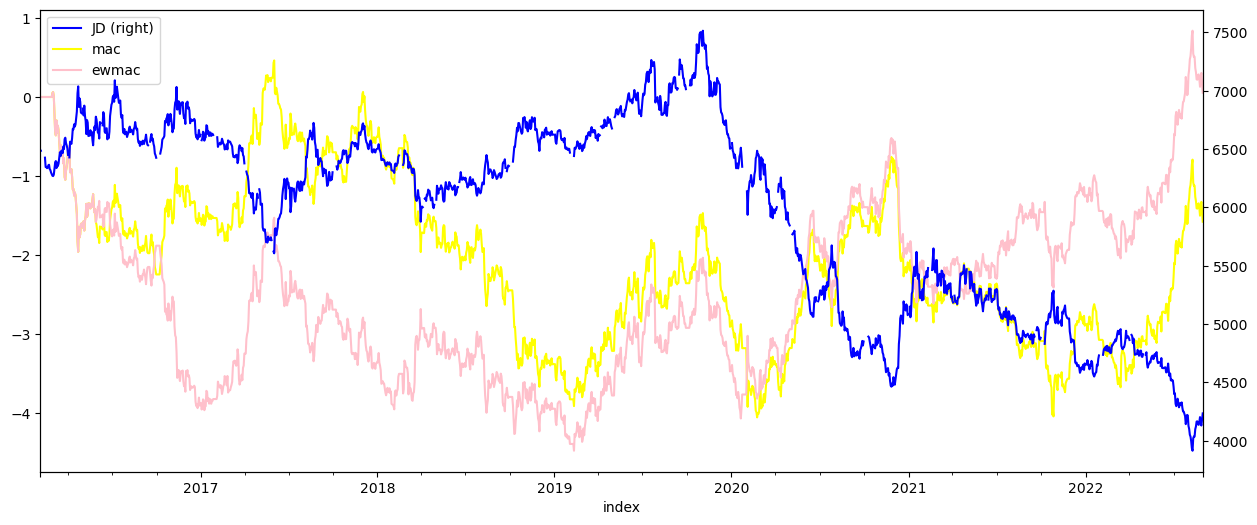

<AxesSubplot:xlabel='index'>

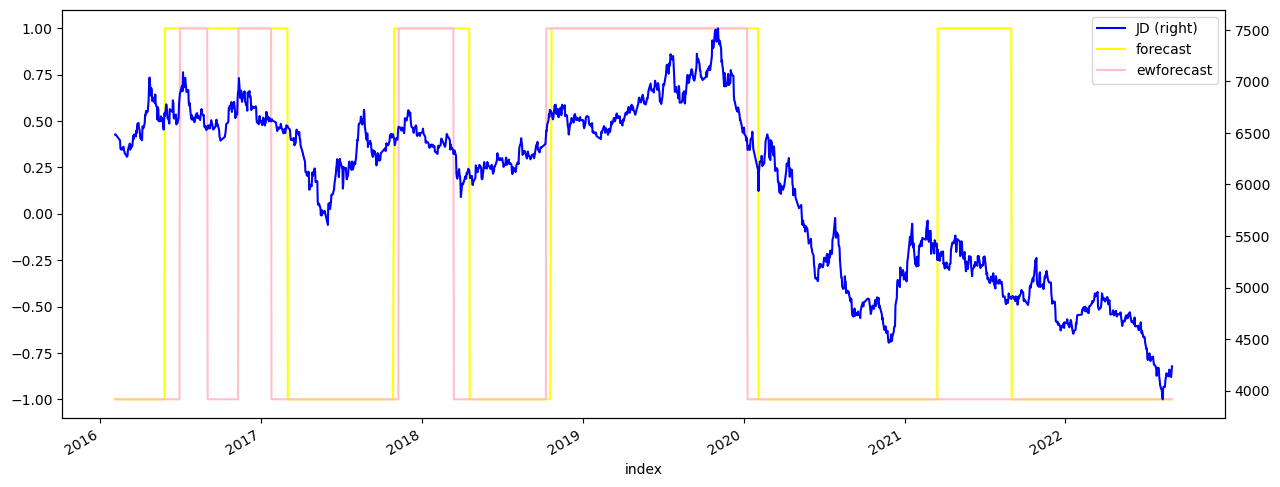

In [131]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
def select(df):
    return df
    # return df[(df.index > '2016-01-01') & (df.index < '2020-01-01')]

account = pandl_for_instrument_forecast(forecast=forecast_df.forecast, price = forecast_df[instrument_code])
ewaccount = pandl_for_instrument_forecast(forecast=forecast_df.ewforecast, price = forecast_df[instrument_code])
print(len(ewaccount))
print(len(account))
print(len(forecast_df[instrument_code]))
print(len(forecast_df.ewforecast))

pl = account.curve().rename('mac')
ewpl = ewaccount.curve().rename('ewmac')
pl_df = pd.concat([forecast_df[instrument_code], pl, ewpl], axis=1)
pl_df = select(pl_df)
pl_df.plot(secondary_y=instrument_code, figsize=(15,6), color=['blue', 'yellow', 'pink'])
forecast_df = select(forecast_df)
plt.show()
forecast_df.plot(figsize=(15,6), color=['blue', 'yellow', 'pink'], secondary_y=instrument_code)

<AxesSubplot:>

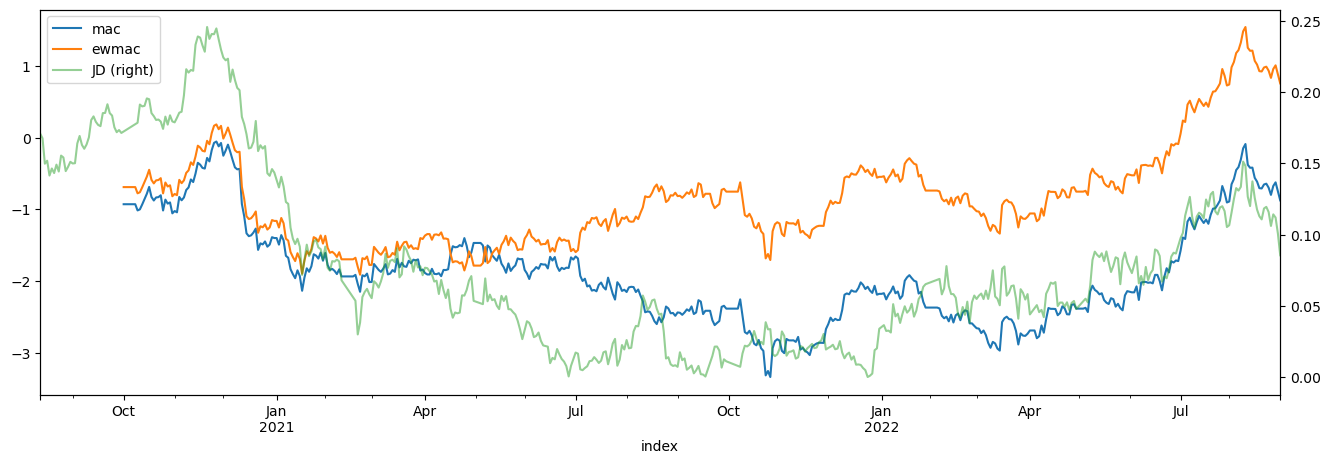

In [106]:
pl.tail(500).plot(legend=True, figsize=(16,5))
ewpl.tail(500).plot(legend=True)
# price.head(500).plot(legend=True, secondary_y=True)

from mdi import rolling_snr
snr = rolling_snr(price.ffill(), slow)
snr.tail(500).plot(legend=True, secondary_y=True, alpha=0.5)